<a href="https://colab.research.google.com/github/khadijabou/Prevision-series-chronologiques-LSTM/blob/main/Consommation__Energie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyse de données de séries chronologiques de la consommation d'énergie électrique des ménages à l'aide du   LSTM**

---







# Nouvelle section

DataSet: l'ensemble de données mesures de la consommation d'énergie d'un ménage avec une fréquence d'échantillonnage d'une minute sur une période 

In [ ]:
#importons tous les package nécessaire:
import sys 
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns # utilisé pour tracer un graphique interactif. 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold # utilisé pour cross validation
from sklearn.preprocessing import StandardScaler #  normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # pour la vérification de l'erreur et de l'exactitude du modèle
from sklearn.metrics import mean_squared_error,r2_score
import tensorflow.keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
# from keras.optimizers import SGD 
from tensorflow.keras.optimizers import Adam,Nadam, SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


## **Traitement des données** 

In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'date' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date')
#  Notez que les données incluent (les données manquantes ) « nan » et « ? » comme une chaîne. on convertir les deux en numpy nan lors de l'étape d'importation aussi on fusionner deux colonnes 'Date' et 'Time' en 'date'. 

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# Cette archive contient 2075259 mesures 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
df.shape

(2075259, 7)

In [ ]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [ ]:
df.describe()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [ ]:
#for j in range(1,7):
 #      print(df.iloc[:, j].unique())

### Traiter les valeurs manquantes 'nan' avec une statistique de test 


In [ ]:
# trouver toutes les colonnes qui ont nan
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
# remplir les valeurs manquantes nan avec la moyenne dans toutes les colonnes
for j in range(0,7):  
        # fillna: méthode pour Remplacez tous les éléments NaN par une valeur = la moyenne dans toutes les colonnes      
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean()) 


In [ ]:
# Contrôle pour s'assurer qu'il n'y a plus de nan:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


Comprendre la distribution des données

Nous pouvons utiliser la fonction de rééchantillonnage resample() pour agréger des caractéristiques dans 
différentes unités. Par exemple, cette fonction est appelée 
avec le paramètre 'H' pour agréger les données indexées dans le temps par heure. Ensuite, nous agrégeons Global_active_power par jour et comparons sa somme et sa moyenne. On peut voir que la moyenne et la somme des ensembles de données rééchantillonnés ont des structures similaires.

In [ ]:
# la somme de puissance active moyenne pour chaque Mois
# pour sous-échantillonner le DataFrame dans des bacs de Mois et additionner les valeurs
df['Global_active_power'].resample('M').sum() 

date
2006-12-31    41817.648460
2007-01-31    69014.045230
2007-02-28    56491.069230
2007-03-31    58863.283615
2007-04-30    39245.548781
2007-05-31    44008.872000
2007-06-30    35729.767447
2007-07-31    29846.831570
2007-08-31    34120.475531
2007-09-30    41874.789230
2007-10-31    49278.553230
2007-11-30    55920.827230
2007-12-31    72605.261615
2008-01-31    65170.473615
2008-02-29    49334.346845
2008-03-31    55591.685615
2008-04-30    48209.992000
2008-05-31    45724.043230
2008-06-30    42945.063615
2008-07-31    35479.601230
2008-08-31    12344.063230
2008-09-30    42667.792000
2008-10-31    50743.399447
2008-11-30    59918.584535
2008-12-31    56911.416668
2009-01-31    62951.099615
2009-02-28    50291.953362
2009-03-31    54761.169230
2009-04-30    49277.707230
2009-05-31    45214.196460
2009-06-30    37149.767696
2009-07-31    27594.810460
2009-08-31    30049.032998
2009-09-30    42631.838845
2009-10-31    51089.811615
2009-11-30    55068.733615
2009-12-31    60907.189

# Visualisation des données:

---



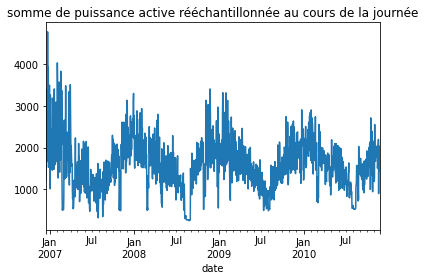

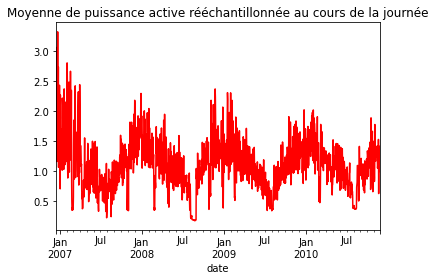

In [ ]:
# Puissance active rééchantillonnée au cours de la journée 
df.Global_active_power.resample('D').sum().plot(title='somme de puissance active rééchantillonnée au cours de la journée') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Moyenne de puissance active rééchantillonnée au cours de la journée', color='red') 
plt.tight_layout()
plt.show()

### Puit on montrer la moyenne et la norme de l'intensité globale rééchantillonnée au cours de la journée

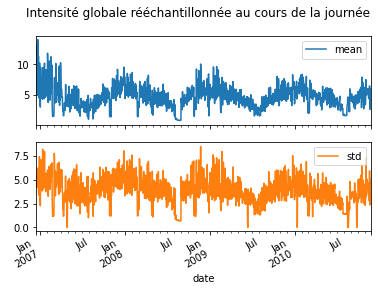

In [ ]:
plt_intensity = df.Global_intensity.resample('D').agg(['mean', 'std'])
plt_intensity.plot(subplots = True, title='Intensité globale rééchantillonnée au cours de la journée')
plt.show()

### Moyenne et la norme de la puissance réactive globale rééchantillonnées au cours de la journée

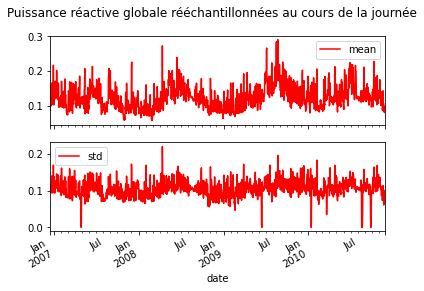

In [ ]:
D_reactive_power = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
D_reactive_power.plot(subplots = True, title='Puissance réactive globale rééchantillonnées au cours de la journée', color='red')
plt.show()

### Somme de la puissance active rééchantillonnée au cours du mois

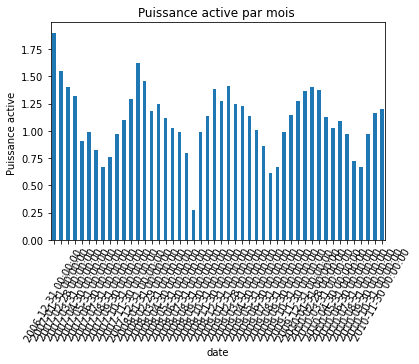

In [ ]:
df.Global_active_power.resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Puissance active ')
plt.title('Puissance active par mois ')
plt.show()

### Moyenne de la puissance active rééchantillonnée sur un trimestre

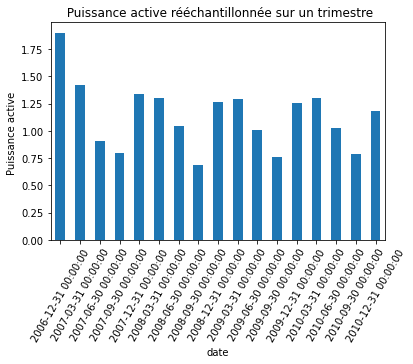

In [ ]:
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Puissance active ')
plt.title(' Puissance active rééchantillonnée sur un trimestre')
plt.show()

### Moyenne de Tension rééchantillonnée sur le mois 

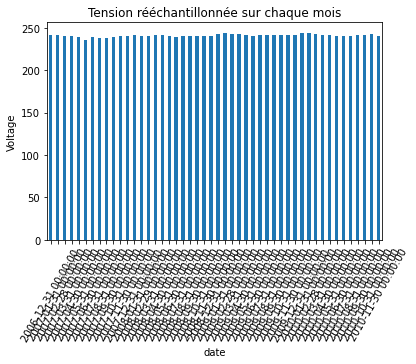

In [ ]:
df['Voltage'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Tension rééchantillonnée sur chaque mois')
plt.show()

Nous pouvons voir que le changement de tension mensuel moyen est très faible et fondamentalement stable.

### Sous-comptage 1 par Mois

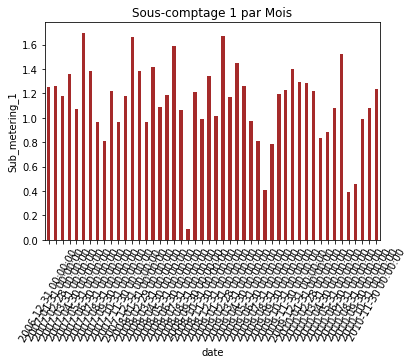

In [ ]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sous-comptage 1 par Mois')
plt.show()

## **la moyenne des différentes caractéristiques rééchantillonnées au cours de la journée.**

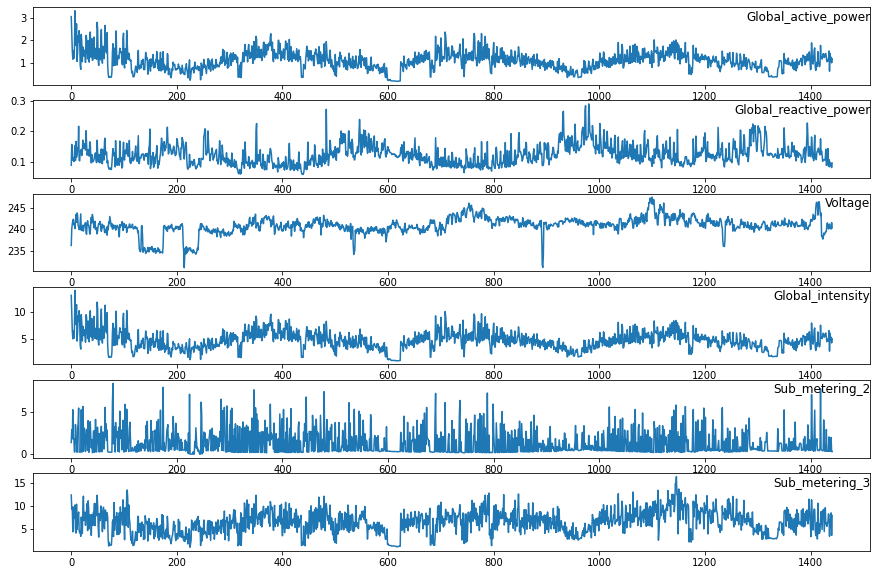

In [ ]:
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
# Moyenne statistique de rééchantillonnage par jour
values = df.resample('D').mean().values
plt.figure(figsize=(15, 10))
for group in groups:
    # sous-graphes à chaque fonctionnalité
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.75, loc='right')
    i += 1
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


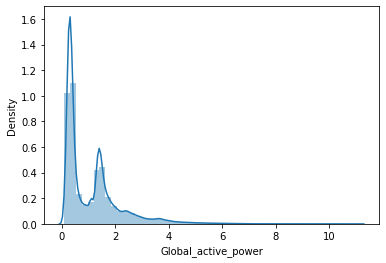

In [ ]:
# Regardons la distribution numérique de la puissance active
sns.distplot(df['Global_active_power'])

On peut voir que la puissance active totale consommée par les ménages est principalement concentrée dans la plage de 0 à 2 kW.

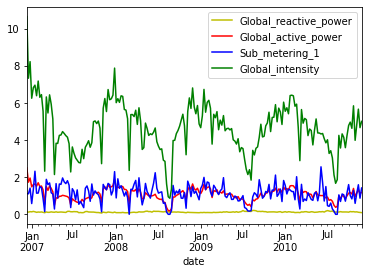

In [ ]:
# rééchantillonnage sur semaine et moyenne de calcul
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

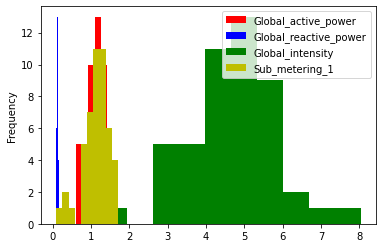

In [ ]:
# l'histogramme de la moyenne des différentes caractéristiques rééchantillonnées au cours du mois
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
#df.Voltage.resample('M').sum().plot(kind='hist',color='g', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

## **Analyse de corrélation caractéristique**

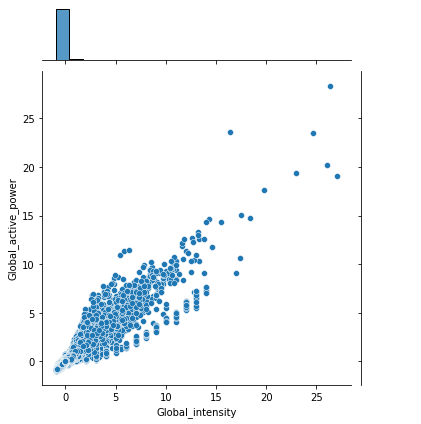

In [ ]:
# Afficher la relation entre les fonctionnalités 'Global_intensity' et 'Global_active_power'
data_returns = df.pct_change()
# pct_change(): Calcule la variation en pourcentage pour comparer le pourcentage de changement dans une série chronologique d'éléments
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  
plt.show()

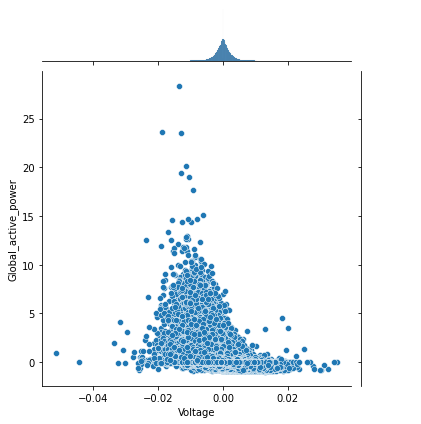

In [ ]:
# correlations entre 'Voltage' et  'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

Comme le montrent les deux figures ci-dessus, 'Global_intensity' et 'Global_active_power' sont liés linéairement. Mais la corrélation entre 'Voltage' et 'Global_active_power' est faible


### Agrégation mensuelle des fonctionnalités, Corrélations de moyenne des caractéristiques rééchantillonnées



In [ ]:
#sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
#            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
#plt.title('without resampling', size=15)
#plt.show()

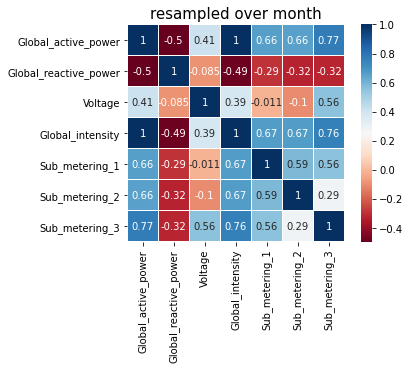

In [ ]:
# Agréger chaque fonctionnalité par Mois

plt.title('resampled over month',size=15)
sns.heatmap(df.resample('M').mean().corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)




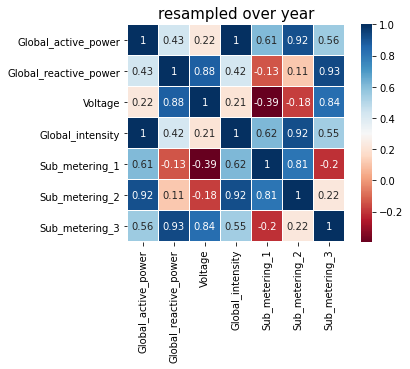

In [ ]:
# Agréger chaque fonctionnalité année par année
plt.title('resampled over year',size=15)
sns.heatmap(df.resample('A').mean().corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

Alors on a une forte correlation entre Global_intensity' et 'Global_active_power'aussi une correlation entre les sous-comptage d'énergie 1,2,3 etl'intensité et avec la Puissance active.

# **Apprentissage automatique : Modèle de prédiction LSTM multivariable** 

le problème de prédiction de séries temporelles doit être ajusté au problème d'apprentissage supervisé pour former des paires de séquences d'entrée et de sortie, et le global_active_power de l'heure précédente et d'autres caractéristiques doivent être utilisés pour prédire l'heure actuelle.

Parce qu'ici, nous prédisons que `Global_active_power' utilise non seulement la 'Global_active_power' du temps passé, mais utilise également d'autres fonctionnalités, telles que 'Voltage', que nous appelons prédiction de séries temporelles multivariables.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n,... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Prediction sequence (t, T + 1,... T + n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Combination
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Lose NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg
    

Nous agrégeons les données en heures, ce qui permet également de réduire le temps de calcul et d'obtenir rapidement les résultats du modèle de test. Nous agrégeons en heures. Cela réduira la taille des données  de 2075259 à 34589 tout en conservant la structure globale des données.

In [ ]:
# rééchantillonnage des données sur une heure
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [ ]:
values = df_resample.values 
# normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Se transformer en problème de supervision
reframed = series_to_supervised(scaled, 1, 1)

# supprimer les colonnes que nous ne voulons pas prédire
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)   var1(t)
1   0.636816   0.295738   0.337945  ...   0.011366   0.782418  0.545045
2   0.545045   0.103358   0.335501  ...   0.144652   0.782676  0.509006
3   0.509006   0.110073   0.283802  ...   0.030869   0.774169  0.488550
4   0.488550   0.096987   0.315987  ...   0.000000   0.778809  0.455597
5   0.455597   0.099010   0.434417  ...   0.008973   0.798917  0.322555

[5 rows x 8 columns]


==> 7 variables d'entrée (série d'entrée) et la 1 variable de sortie pour 'Global_active_power' à l'heure actuelle en heure (en fonction du rééchantillonnage). 


Divisez les ensembles de données en ensembles d'apprentissage et en ensembles de test
Ici, nous utilisons les données des trois premières années comme ensemble d'apprentissage et les échantillons de l'année suivante comme ensemble de test, et modifions les données en format tridimensionnel.

In [ ]:
# divisé en ensembles de train et de test
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
# divisé en  input et outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input en 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 


(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


Construire le modèle LSTM

---
Architecture modèle 
1) LSTM avec 100 neurones dans la première couche visible 

3) abandon 20%

4) 1 neurone dans la couche de sortie pour prédire Global_active_power. 

5) La forme d'entrée sera 1 pas de temps avec 7 caractéristiques. 

6) J'utilise la fonction de perte d'erreur absolue moyenne  et la version Adam efficace de la descente de gradient stochastique. 

7) Le modèle sera adapté à 20 époques d'entraînement avec une taille de lot de 70.

Epoch 1/20
126/126 - 21s - loss: 0.0214 - val_loss: 0.0126
Epoch 2/20
126/126 - 1s - loss: 0.0130 - val_loss: 0.0108
Epoch 3/20
126/126 - 1s - loss: 0.0117 - val_loss: 0.0099
Epoch 4/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0094
Epoch 5/20
126/126 - 1s - loss: 0.0107 - val_loss: 0.0093
Epoch 6/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0091
Epoch 7/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0092
Epoch 8/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 9/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0091
Epoch 10/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0091
Epoch 11/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 12/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 13/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 14/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 15/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 16/20
126/126 - 1s - loss: 0.0103 - val_loss: 0.0092
Epoch 17/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch

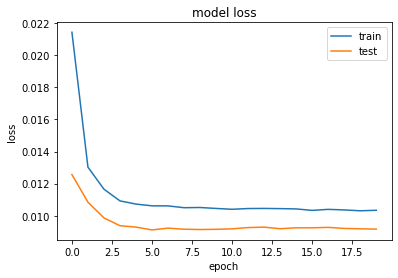

In [ ]:
# Construire le modèle 
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Training network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Valeur de perte loss value
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
#  prédiction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))


On voit que la vitesse de convergence du modèle est très rapide.

#### Évaluation du modèle


Afin de juger efficacement les performances d'un modèle de prévision, un ensemble d'ensembles de données sans participer au modèle de prévision est nécessaire, et la précision du modèle de prévision est évaluée sur le modèle. Cet ensemble de données indépendantes est utilisé pour évaluer la précision du modèle de prévision. Les ensembles sont appelés ensembles de test.

Nous combinons la prédiction avec des ensembles de données de test et une mise à l'échelle inversée. Sur la base de l'échelle d'origine des valeurs prédites et réelles, nous pouvons calculer la fraction d'erreur du modèle. Dans ce cas, nous calculons l'erreur quadratique moyenne (RMSE) de l'erreur générée par la même unité que la variable elle-même.

In [ ]:
# Inversion et mise à l'échelle des valeurs prédites
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Inversion et mise à l'échelle des valeurs réelles
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculons RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.650


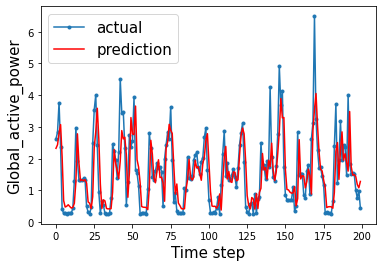

In [ ]:
# Comparons les valeurs réelles et prévues pour les 200 prochaines heures
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()